# Mask R-CNN - Train on ADE20K_COCO Dataset


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

import optuna

SEED = 10
np.random.seed(SEED)


# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [4]:
# Ignore Tensorflow Deprecation Warnings
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# Ignore additional warnings
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [5]:
import ade20k_coco
from ade20k_coco import Ade20kCocoConfig, Ade20kCocoDataset

# TODO: enter relative path to dataset
DATASET_ROOT = os.path.join(ROOT_DIR, "datasets/ade20k_coco_v4") 

## Load Dataset

In [6]:
dataset_train = ade20k_coco.Ade20kCocoDataset()
dataset_train.load_coco(DATASET_ROOT, "train")

dataset_val = ade20k_coco.Ade20kCocoDataset()
dataset_val.load_coco(DATASET_ROOT, "val")


# Must call before using the dataset
dataset_train.prepare()
dataset_val.prepare()

print(f"Image Count (train/val): {len(dataset_train.image_ids)}/{len(dataset_val.image_ids)}")
print("Class Count: {}".format(dataset_train.num_classes))

for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Image Count (train/val): 4987/500
Class Count: 5
  0. BG                                                
  1. ceiling                                           
  2. floor, flooring                                   
  3. wall                                              
  4. windowpane, window                                


## Notebook Preferences

In [7]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Reusable Trial Function

In [8]:
from ds_toolbox.ds_logging import add_log_file, set_log_level
from ds_toolbox.ds_logging import info, debug, warn, error
set_log_level("debug")

In [10]:
def compute_map_val(model, model_path):
    # Load trained weights
    debug("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)
    
    # Compute VOC-Style mAP @ IoU=0.5
    # Running on N=30 images. Increase for better accuracy.
    image_ids = np.random.choice(dataset_val.image_ids, 210)
    APs = []
    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)

    mAP = np.mean(APs)
    return mAP

In [11]:
def select_epoch(model):
    model_path = model.find_last()
    debug(f"MODEL PATH: {model_path}")
    mAP = compute_map_val(model, model_path)
    info("mAP {:.04f}".format(epoch, mAP))

In [13]:
class InferenceConfig(Ade20kCocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [14]:
%%time
select_epoch(model)

04/13/2020 08:34:19 PM [DEBUG] MODEL PATH: /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200413T1922/mask_rcnn_ade20k_coco_v4_0008.h5
04/13/2020 08:34:19 PM [DEBUG] Loading weights from /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200413T1922/mask_rcnn_ade20k_coco_v4_0008.h5


Re-starting from epoch 8


NameError: name 'epoch' is not defined

Image id: 117
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 2580.00000  float64
gt_class_id              shape: (4,)                  min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (4, 4)                min:    0.00000  max: 1023.00000  int32
gt_mask                  shape: (1024, 1024, 4)       min:    0.00000  max:    1.00000  bool


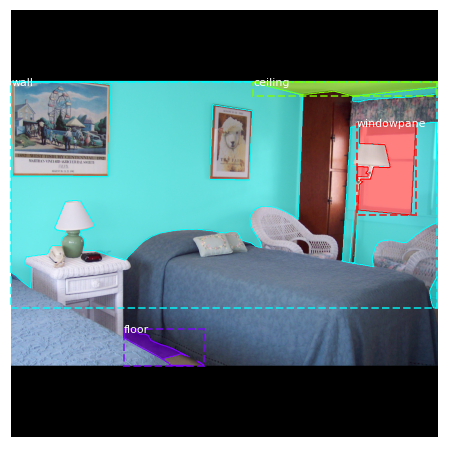

In [15]:
image_id = 117
print(f"Image id: {image_id}")

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

04/13/2020 08:36:37 PM [INFO] Loading weights from /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200413T1922/mask_rcnn_ade20k_coco_v4_0007.h5 for epoch 7


Re-starting from epoch 7
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


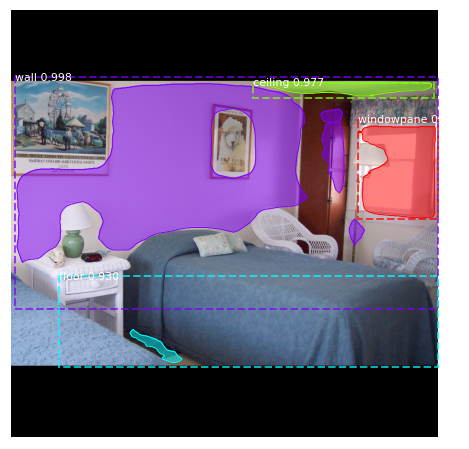

In [20]:
epoch = 7
model_path = model.find_last()
model_path = model_path[:-7] + "{:04d}.h5".format(epoch)

# Load trained weights
info(f"Loading weights from {model_path} for epoch {epoch}")
model.load_weights(model_path, by_name=True)

results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

04/13/2020 08:36:38 PM [INFO] Loading weights from /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200413T1922/mask_rcnn_ade20k_coco_v4_0008.h5 for epoch 8


Re-starting from epoch 8
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


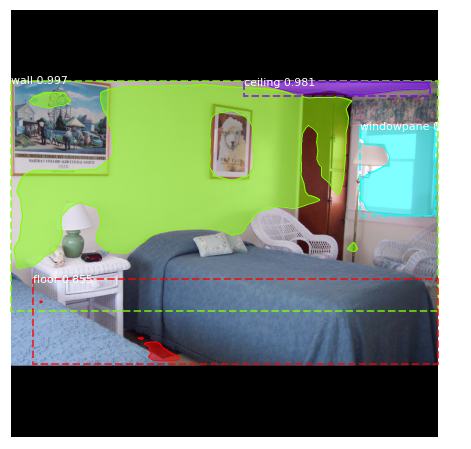

In [21]:
epoch = 8
model_path = model.find_last()
model_path = model_path[:-7] + "{:04d}.h5".format(epoch)

# Load trained weights
info(f"Loading weights from {model_path} for epoch {epoch}")
model.load_weights(model_path, by_name=True)

results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [24]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
r['rois'], r['masks'], r['class_ids'], r['scores']

In [26]:
results[0]

{'rois': array([[ 167,    0,  721, 1024],
        [ 170,  558,  203, 1005],
        [ 278,  836,  493, 1019],
        [ 643,   53,  848, 1024]], dtype=int32),
 'class_ids': array([3, 1, 4, 2], dtype=int32),
 'scores': array([0.9965503, 0.9805925, 0.8820899, 0.8550565], dtype=float32),
 'masks': array([[[False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         ...,
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False]],
 
        [[False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         ...,
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False]],
 
        [[False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         ...,
         [False, False, False, False],
         [False, False, False, Fa